# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

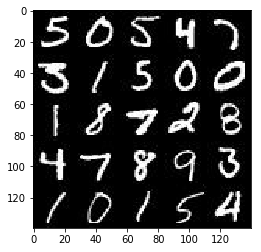

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

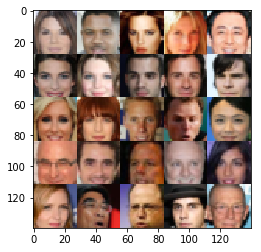

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s) //dataset will be in the range of -0.5 to 0.5 of 28x28
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Improvements: use odd-sized filters. Kernel size of 5 is a better choice nstead of 4.
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = leakyReLU(c1, alpha)
    
        #print(relu1.shape)
        # now 14x14x64
        
        c2 = tf.layers.conv2d(relu1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = leakyReLU(bn2, alpha)
        
        #print(relu2.shape)
        # now 7x7x128
        
        c3 = tf.layers.conv2d(relu2, filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = leakyReLU(bn3, alpha)
        
        #print(relu3.shape)
        # now 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    # Model tipss:
    # - use 5 layers, 3 layers are not enough
    # - generators which are sufficiently larger than the discriminator tend to produce better samples
    
    with tf.variable_scope('generator', reuse=not is_train):
        # project input vector with fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leakyReLU(bn1)
        
        #print(relu1.shape)
        # 7x7x1024 now
        
        ct2 = tf.layers.conv2d_transpose(relu1, 512, kernel_size=(5,5), strides=(2,2), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(ct2, training=is_train)
        relu2 = leakyReLU(bn2)
        
        #print(relu2.shape)
        # 14x14x512 now
        
        ct3 = tf.layers.conv2d_transpose(relu2, 256, kernel_size=(5,5), strides=(2,2), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(ct3, training=is_train)
        relu3 = leakyReLU(bn3)
        
        #print(relu3.shape)
        # 28x28x256 now
        
        ct4 = tf.layers.conv2d_transpose(relu3, 128, kernel_size=(5,5), strides=(2,2), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn4 = tf.layers.batch_normalization(ct4, training=is_train)
        relu4 = leakyReLU(bn4)
        
        #print(relu4.shape)
        # 56x56x128 now

        ct5 = tf.layers.conv2d_transpose(relu4, 64, kernel_size=(5,5), strides=(2,2), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn5 = tf.layers.batch_normalization(ct5, training=is_train)
        relu5 = leakyReLU(bn5)
        
        #print(relu5.shape)
        # 112x112x64 now

        # Output layer
        # strides 1 to avoid checkerboard-like artifacts in the generated images. See: https://distill.pub/2016/deconv-checkerboard/
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, kernel_size=(5,5), strides=(1,1), padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        #print(logits.shape)
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    g_out_fake = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(g_out_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_out_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_out_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   
    
    #? tf.reset_default_graph()
    print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    
    # get placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # get losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # get optimizers    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Train Model
    print_every = 25
    show_every = 200
    saver = tf.train.Saver()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images: 
                #   The output from the generator is bound between -1 and 1 as tanh activation function is used in the output layer. 
                #   The input batch images are in the range -0.5 to 0.5. They must be scaled to match the values as in generated image. 
                batch_images = batch_images * 2
                
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr:learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})

                    print("Epoch: {}/{};".format(epoch_i+1, epochs),
                          "Batch: {:5d};".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                    
        saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch: 1/2; Batch:    25; Discriminator Loss: 0.3512... Generator Loss: 6.9014
Epoch: 1/2; Batch:    50; Discriminator Loss: 1.6207... Generator Loss: 0.4772
Epoch: 1/2; Batch:    75; Discriminator Loss: 1.6838... Generator Loss: 0.5157
Epoch: 1/2; Batch:   100; Discriminator Loss: 1.2796... Generator Loss: 0.9815
Epoch: 1/2; Batch:   125; Discriminator Loss: 1.2850... Generator Loss: 1.1187
Epoch: 1/2; Batch:   150; Discriminator Loss: 0.8171... Generator Loss: 1.9822
Epoch: 1/2; Batch:   175; Discriminator Loss: 1.4089... Generator Loss: 0.5431
Epoch: 1/2; Batch:   200; Discriminator Loss: 1.6790... Generator Loss: 0.3827


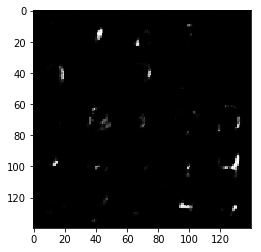

Epoch: 1/2; Batch:   225; Discriminator Loss: 1.7967... Generator Loss: 0.3396
Epoch: 1/2; Batch:   250; Discriminator Loss: 1.2125... Generator Loss: 1.6303
Epoch: 1/2; Batch:   275; Discriminator Loss: 1.0699... Generator Loss: 1.1644
Epoch: 1/2; Batch:   300; Discriminator Loss: 1.1127... Generator Loss: 0.8486
Epoch: 1/2; Batch:   325; Discriminator Loss: 1.3633... Generator Loss: 0.7898
Epoch: 1/2; Batch:   350; Discriminator Loss: 1.2211... Generator Loss: 0.7165
Epoch: 1/2; Batch:   375; Discriminator Loss: 1.2254... Generator Loss: 0.8035
Epoch: 1/2; Batch:   400; Discriminator Loss: 1.4748... Generator Loss: 0.4527


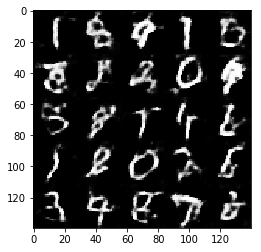

Epoch: 1/2; Batch:   425; Discriminator Loss: 1.2050... Generator Loss: 0.9794
Epoch: 1/2; Batch:   450; Discriminator Loss: 1.3565... Generator Loss: 1.6032
Epoch: 1/2; Batch:   475; Discriminator Loss: 1.2308... Generator Loss: 0.7221
Epoch: 1/2; Batch:   500; Discriminator Loss: 1.3199... Generator Loss: 0.7069
Epoch: 1/2; Batch:   525; Discriminator Loss: 1.2447... Generator Loss: 1.0528
Epoch: 1/2; Batch:   550; Discriminator Loss: 1.2850... Generator Loss: 1.4600
Epoch: 1/2; Batch:   575; Discriminator Loss: 1.1756... Generator Loss: 0.8834
Epoch: 1/2; Batch:   600; Discriminator Loss: 1.3053... Generator Loss: 1.3126


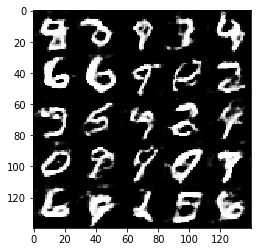

Epoch: 1/2; Batch:   625; Discriminator Loss: 1.3840... Generator Loss: 0.5486
Epoch: 1/2; Batch:   650; Discriminator Loss: 1.1614... Generator Loss: 0.8354
Epoch: 1/2; Batch:   675; Discriminator Loss: 1.2759... Generator Loss: 0.7119
Epoch: 1/2; Batch:   700; Discriminator Loss: 1.3093... Generator Loss: 0.5974
Epoch: 1/2; Batch:   725; Discriminator Loss: 1.1907... Generator Loss: 0.9652
Epoch: 1/2; Batch:   750; Discriminator Loss: 1.9218... Generator Loss: 0.2644
Epoch: 1/2; Batch:   775; Discriminator Loss: 1.1119... Generator Loss: 1.0807
Epoch: 1/2; Batch:   800; Discriminator Loss: 1.3546... Generator Loss: 0.7689


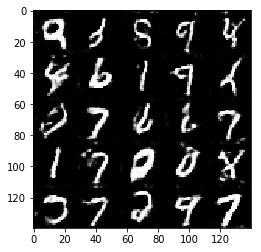

Epoch: 1/2; Batch:   825; Discriminator Loss: 1.1650... Generator Loss: 1.2407
Epoch: 1/2; Batch:   850; Discriminator Loss: 1.2835... Generator Loss: 0.9047
Epoch: 1/2; Batch:   875; Discriminator Loss: 1.3192... Generator Loss: 0.5851
Epoch: 1/2; Batch:   900; Discriminator Loss: 1.2701... Generator Loss: 1.5952
Epoch: 1/2; Batch:   925; Discriminator Loss: 1.2028... Generator Loss: 0.6787
Epoch: 2/2; Batch:   950; Discriminator Loss: 1.2128... Generator Loss: 0.8070
Epoch: 2/2; Batch:   975; Discriminator Loss: 1.3211... Generator Loss: 0.6450
Epoch: 2/2; Batch:  1000; Discriminator Loss: 1.2294... Generator Loss: 0.7354


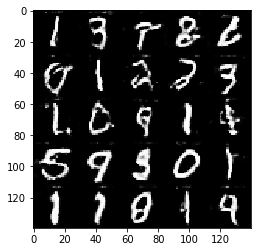

Epoch: 2/2; Batch:  1025; Discriminator Loss: 1.1668... Generator Loss: 0.8031
Epoch: 2/2; Batch:  1050; Discriminator Loss: 1.4173... Generator Loss: 0.5864
Epoch: 2/2; Batch:  1075; Discriminator Loss: 1.1817... Generator Loss: 0.8608
Epoch: 2/2; Batch:  1100; Discriminator Loss: 1.1011... Generator Loss: 1.0389
Epoch: 2/2; Batch:  1125; Discriminator Loss: 1.2785... Generator Loss: 0.6289
Epoch: 2/2; Batch:  1150; Discriminator Loss: 1.0878... Generator Loss: 1.1689
Epoch: 2/2; Batch:  1175; Discriminator Loss: 1.1881... Generator Loss: 0.9248
Epoch: 2/2; Batch:  1200; Discriminator Loss: 1.0885... Generator Loss: 0.7969


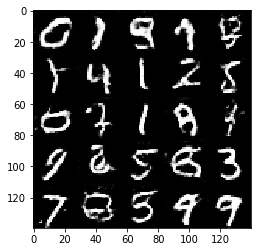

Epoch: 2/2; Batch:  1225; Discriminator Loss: 0.9841... Generator Loss: 0.9998
Epoch: 2/2; Batch:  1250; Discriminator Loss: 0.9702... Generator Loss: 1.0158
Epoch: 2/2; Batch:  1275; Discriminator Loss: 1.1262... Generator Loss: 1.0141
Epoch: 2/2; Batch:  1300; Discriminator Loss: 1.2745... Generator Loss: 0.7098
Epoch: 2/2; Batch:  1325; Discriminator Loss: 1.4498... Generator Loss: 0.4655
Epoch: 2/2; Batch:  1350; Discriminator Loss: 1.1464... Generator Loss: 1.6581
Epoch: 2/2; Batch:  1375; Discriminator Loss: 0.9992... Generator Loss: 1.1972
Epoch: 2/2; Batch:  1400; Discriminator Loss: 0.6946... Generator Loss: 1.6300


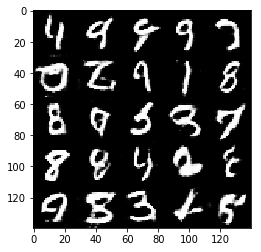

Epoch: 2/2; Batch:  1425; Discriminator Loss: 1.0432... Generator Loss: 0.8203
Epoch: 2/2; Batch:  1450; Discriminator Loss: 1.0054... Generator Loss: 1.5372
Epoch: 2/2; Batch:  1475; Discriminator Loss: 0.7992... Generator Loss: 1.9998
Epoch: 2/2; Batch:  1500; Discriminator Loss: 1.2036... Generator Loss: 0.7812
Epoch: 2/2; Batch:  1525; Discriminator Loss: 1.2897... Generator Loss: 1.6605
Epoch: 2/2; Batch:  1550; Discriminator Loss: 1.0191... Generator Loss: 1.1160
Epoch: 2/2; Batch:  1575; Discriminator Loss: 1.4323... Generator Loss: 0.4829
Epoch: 2/2; Batch:  1600; Discriminator Loss: 1.0292... Generator Loss: 0.9955


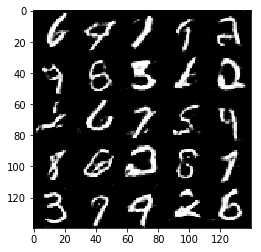

Epoch: 2/2; Batch:  1625; Discriminator Loss: 0.8638... Generator Loss: 1.4058
Epoch: 2/2; Batch:  1650; Discriminator Loss: 1.0906... Generator Loss: 1.5326
Epoch: 2/2; Batch:  1675; Discriminator Loss: 1.2720... Generator Loss: 2.0494
Epoch: 2/2; Batch:  1700; Discriminator Loss: 1.0334... Generator Loss: 1.0417
Epoch: 2/2; Batch:  1725; Discriminator Loss: 1.3151... Generator Loss: 0.5587
Epoch: 2/2; Batch:  1750; Discriminator Loss: 1.0909... Generator Loss: 1.8439
Epoch: 2/2; Batch:  1775; Discriminator Loss: 1.5943... Generator Loss: 0.4116
Epoch: 2/2; Batch:  1800; Discriminator Loss: 0.6400... Generator Loss: 1.6332


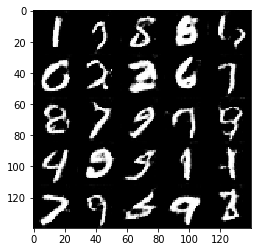

Epoch: 2/2; Batch:  1825; Discriminator Loss: 1.0372... Generator Loss: 0.8466
Epoch: 2/2; Batch:  1850; Discriminator Loss: 2.5384... Generator Loss: 3.6406


In [12]:
batch_size = 32
z_dim = 200
learning_rate = 0.001
beta1 = 0.2
# ==> Generator Loss gets bigger over, imgages gets bader

batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch: 1/1; Batch:    25; Discriminator Loss: 0.7522... Generator Loss: 16.6697
Epoch: 1/1; Batch:    50; Discriminator Loss: 0.5600... Generator Loss: 2.2645
Epoch: 1/1; Batch:    75; Discriminator Loss: 0.9818... Generator Loss: 2.2245
Epoch: 1/1; Batch:   100; Discriminator Loss: 0.6812... Generator Loss: 1.6378
Epoch: 1/1; Batch:   125; Discriminator Loss: 0.4547... Generator Loss: 6.0388
Epoch: 1/1; Batch:   150; Discriminator Loss: 0.5814... Generator Loss: 1.9534
Epoch: 1/1; Batch:   175; Discriminator Loss: 1.6750... Generator Loss: 0.4415
Epoch: 1/1; Batch:   200; Discriminator Loss: 1.6457... Generator Loss: 0.4315


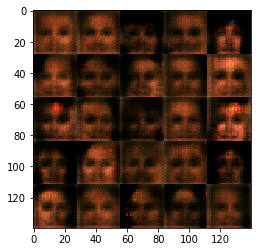

Epoch: 1/1; Batch:   225; Discriminator Loss: 1.2394... Generator Loss: 1.4576
Epoch: 1/1; Batch:   250; Discriminator Loss: 1.1441... Generator Loss: 0.9832
Epoch: 1/1; Batch:   275; Discriminator Loss: 1.3083... Generator Loss: 0.6759
Epoch: 1/1; Batch:   300; Discriminator Loss: 1.5830... Generator Loss: 0.4001
Epoch: 1/1; Batch:   325; Discriminator Loss: 1.3308... Generator Loss: 1.4213
Epoch: 1/1; Batch:   350; Discriminator Loss: 1.4695... Generator Loss: 0.4482
Epoch: 1/1; Batch:   375; Discriminator Loss: 1.2702... Generator Loss: 0.5672
Epoch: 1/1; Batch:   400; Discriminator Loss: 1.3239... Generator Loss: 1.1128


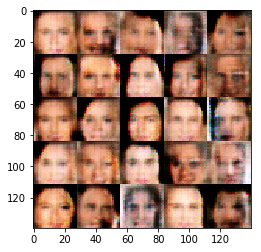

Epoch: 1/1; Batch:   425; Discriminator Loss: 2.4713... Generator Loss: 3.3434
Epoch: 1/1; Batch:   450; Discriminator Loss: 1.0629... Generator Loss: 1.0088
Epoch: 1/1; Batch:   475; Discriminator Loss: 1.4091... Generator Loss: 0.8029
Epoch: 1/1; Batch:   500; Discriminator Loss: 1.3130... Generator Loss: 0.8575
Epoch: 1/1; Batch:   525; Discriminator Loss: 1.1845... Generator Loss: 1.0119
Epoch: 1/1; Batch:   550; Discriminator Loss: 1.2476... Generator Loss: 1.1607
Epoch: 1/1; Batch:   575; Discriminator Loss: 1.3884... Generator Loss: 0.6743
Epoch: 1/1; Batch:   600; Discriminator Loss: 3.0464... Generator Loss: 2.9466


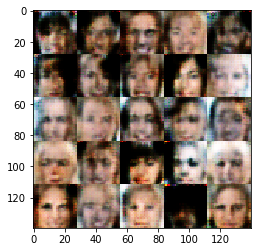

Epoch: 1/1; Batch:   625; Discriminator Loss: 1.2877... Generator Loss: 0.6750
Epoch: 1/1; Batch:   650; Discriminator Loss: 1.1932... Generator Loss: 1.6551
Epoch: 1/1; Batch:   675; Discriminator Loss: 0.7312... Generator Loss: 2.5877
Epoch: 1/1; Batch:   700; Discriminator Loss: 1.2693... Generator Loss: 0.6337
Epoch: 1/1; Batch:   725; Discriminator Loss: 1.4405... Generator Loss: 0.5808
Epoch: 1/1; Batch:   750; Discriminator Loss: 1.1284... Generator Loss: 0.8673
Epoch: 1/1; Batch:   775; Discriminator Loss: 1.5806... Generator Loss: 0.5230
Epoch: 1/1; Batch:   800; Discriminator Loss: 1.3505... Generator Loss: 0.6510


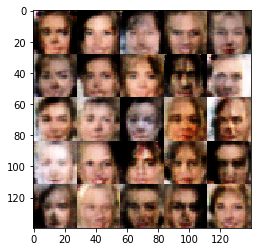

Epoch: 1/1; Batch:   825; Discriminator Loss: 1.3275... Generator Loss: 0.6741
Epoch: 1/1; Batch:   850; Discriminator Loss: 1.1508... Generator Loss: 1.3836
Epoch: 1/1; Batch:   875; Discriminator Loss: 1.2877... Generator Loss: 0.6691
Epoch: 1/1; Batch:   900; Discriminator Loss: 1.2781... Generator Loss: 0.7936
Epoch: 1/1; Batch:   925; Discriminator Loss: 1.2674... Generator Loss: 1.2836
Epoch: 1/1; Batch:   950; Discriminator Loss: 1.0603... Generator Loss: 1.1343
Epoch: 1/1; Batch:   975; Discriminator Loss: 1.0057... Generator Loss: 1.2616
Epoch: 1/1; Batch:  1000; Discriminator Loss: 1.1655... Generator Loss: 0.8956


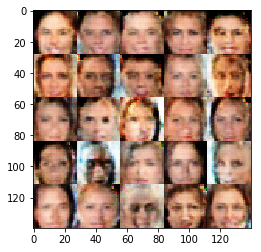

Epoch: 1/1; Batch:  1025; Discriminator Loss: 1.1755... Generator Loss: 0.9034
Epoch: 1/1; Batch:  1050; Discriminator Loss: 1.3260... Generator Loss: 0.5500
Epoch: 1/1; Batch:  1075; Discriminator Loss: 1.1760... Generator Loss: 0.7452
Epoch: 1/1; Batch:  1100; Discriminator Loss: 0.7129... Generator Loss: 1.5388
Epoch: 1/1; Batch:  1125; Discriminator Loss: 1.0807... Generator Loss: 0.7729
Epoch: 1/1; Batch:  1150; Discriminator Loss: 1.3731... Generator Loss: 0.9577
Epoch: 1/1; Batch:  1175; Discriminator Loss: 1.2317... Generator Loss: 0.9554
Epoch: 1/1; Batch:  1200; Discriminator Loss: 1.3042... Generator Loss: 0.5284


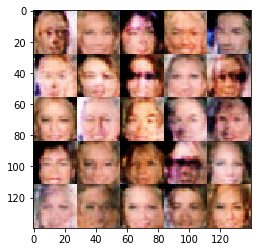

Epoch: 1/1; Batch:  1225; Discriminator Loss: 1.0672... Generator Loss: 0.7670
Epoch: 1/1; Batch:  1250; Discriminator Loss: 1.4620... Generator Loss: 1.2690
Epoch: 1/1; Batch:  1275; Discriminator Loss: 1.1504... Generator Loss: 0.7823
Epoch: 1/1; Batch:  1300; Discriminator Loss: 1.2548... Generator Loss: 0.7109
Epoch: 1/1; Batch:  1325; Discriminator Loss: 1.2575... Generator Loss: 0.6695
Epoch: 1/1; Batch:  1350; Discriminator Loss: 1.2633... Generator Loss: 1.5113
Epoch: 1/1; Batch:  1375; Discriminator Loss: 1.3696... Generator Loss: 1.1938
Epoch: 1/1; Batch:  1400; Discriminator Loss: 1.4263... Generator Loss: 0.7151


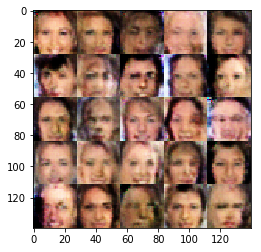

Epoch: 1/1; Batch:  1425; Discriminator Loss: 1.5060... Generator Loss: 1.1109
Epoch: 1/1; Batch:  1450; Discriminator Loss: 1.3118... Generator Loss: 0.7986
Epoch: 1/1; Batch:  1475; Discriminator Loss: 1.3725... Generator Loss: 0.4692
Epoch: 1/1; Batch:  1500; Discriminator Loss: 0.8916... Generator Loss: 1.2445
Epoch: 1/1; Batch:  1525; Discriminator Loss: 1.6923... Generator Loss: 0.3495
Epoch: 1/1; Batch:  1550; Discriminator Loss: 1.3042... Generator Loss: 0.5819
Epoch: 1/1; Batch:  1575; Discriminator Loss: 0.7761... Generator Loss: 1.2212
Epoch: 1/1; Batch:  1600; Discriminator Loss: 1.5834... Generator Loss: 1.8136


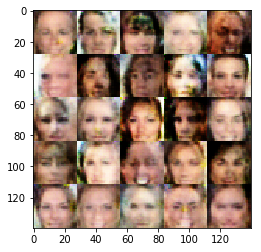

Epoch: 1/1; Batch:  1625; Discriminator Loss: 1.2713... Generator Loss: 1.3534
Epoch: 1/1; Batch:  1650; Discriminator Loss: 1.3288... Generator Loss: 0.6877
Epoch: 1/1; Batch:  1675; Discriminator Loss: 1.1428... Generator Loss: 0.9464
Epoch: 1/1; Batch:  1700; Discriminator Loss: 1.3782... Generator Loss: 0.9041
Epoch: 1/1; Batch:  1725; Discriminator Loss: 1.2545... Generator Loss: 0.8542
Epoch: 1/1; Batch:  1750; Discriminator Loss: 1.3209... Generator Loss: 1.0217
Epoch: 1/1; Batch:  1775; Discriminator Loss: 1.4474... Generator Loss: 0.7739
Epoch: 1/1; Batch:  1800; Discriminator Loss: 1.0634... Generator Loss: 0.8690


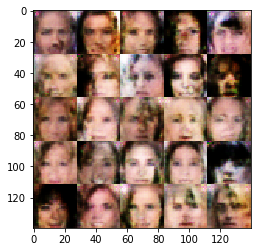

Epoch: 1/1; Batch:  1825; Discriminator Loss: 1.1177... Generator Loss: 0.8549
Epoch: 1/1; Batch:  1850; Discriminator Loss: 1.1103... Generator Loss: 1.0201
Epoch: 1/1; Batch:  1875; Discriminator Loss: 1.2974... Generator Loss: 0.8164
Epoch: 1/1; Batch:  1900; Discriminator Loss: 1.2789... Generator Loss: 1.6993
Epoch: 1/1; Batch:  1925; Discriminator Loss: 1.1631... Generator Loss: 0.6684
Epoch: 1/1; Batch:  1950; Discriminator Loss: 1.4729... Generator Loss: 1.5560
Epoch: 1/1; Batch:  1975; Discriminator Loss: 1.2935... Generator Loss: 0.6021
Epoch: 1/1; Batch:  2000; Discriminator Loss: 1.0961... Generator Loss: 1.2354


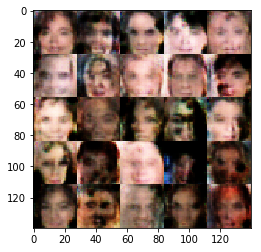

Epoch: 1/1; Batch:  2025; Discriminator Loss: 3.0577... Generator Loss: 3.6330
Epoch: 1/1; Batch:  2050; Discriminator Loss: 1.4072... Generator Loss: 0.6602
Epoch: 1/1; Batch:  2075; Discriminator Loss: 1.6101... Generator Loss: 0.3676
Epoch: 1/1; Batch:  2100; Discriminator Loss: 1.2542... Generator Loss: 0.5792
Epoch: 1/1; Batch:  2125; Discriminator Loss: 0.8818... Generator Loss: 1.0156
Epoch: 1/1; Batch:  2150; Discriminator Loss: 1.3073... Generator Loss: 1.5225
Epoch: 1/1; Batch:  2175; Discriminator Loss: 1.0935... Generator Loss: 1.1741
Epoch: 1/1; Batch:  2200; Discriminator Loss: 1.0851... Generator Loss: 0.9418


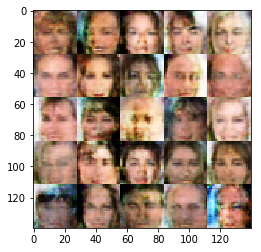

Epoch: 1/1; Batch:  2225; Discriminator Loss: 1.2404... Generator Loss: 1.6944
Epoch: 1/1; Batch:  2250; Discriminator Loss: 1.2749... Generator Loss: 0.6048
Epoch: 1/1; Batch:  2275; Discriminator Loss: 1.4448... Generator Loss: 0.7997
Epoch: 1/1; Batch:  2300; Discriminator Loss: 1.4960... Generator Loss: 2.0130
Epoch: 1/1; Batch:  2325; Discriminator Loss: 1.7191... Generator Loss: 1.7406
Epoch: 1/1; Batch:  2350; Discriminator Loss: 1.2292... Generator Loss: 0.7582
Epoch: 1/1; Batch:  2375; Discriminator Loss: 1.1006... Generator Loss: 1.1756
Epoch: 1/1; Batch:  2400; Discriminator Loss: 1.5910... Generator Loss: 0.3703


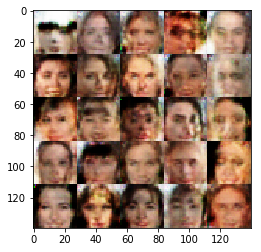

Epoch: 1/1; Batch:  2425; Discriminator Loss: 1.3942... Generator Loss: 0.9859
Epoch: 1/1; Batch:  2450; Discriminator Loss: 1.2774... Generator Loss: 0.9865
Epoch: 1/1; Batch:  2475; Discriminator Loss: 1.1554... Generator Loss: 0.8460
Epoch: 1/1; Batch:  2500; Discriminator Loss: 1.3081... Generator Loss: 0.5884
Epoch: 1/1; Batch:  2525; Discriminator Loss: 1.4154... Generator Loss: 0.4494
Epoch: 1/1; Batch:  2550; Discriminator Loss: 1.4008... Generator Loss: 0.8096
Epoch: 1/1; Batch:  2575; Discriminator Loss: 2.2537... Generator Loss: 2.4033
Epoch: 1/1; Batch:  2600; Discriminator Loss: 1.1425... Generator Loss: 1.4535


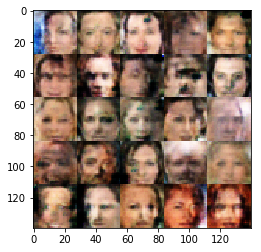

Epoch: 1/1; Batch:  2625; Discriminator Loss: 0.8654... Generator Loss: 1.3517
Epoch: 1/1; Batch:  2650; Discriminator Loss: 1.3223... Generator Loss: 1.8268
Epoch: 1/1; Batch:  2675; Discriminator Loss: 0.9828... Generator Loss: 0.9263
Epoch: 1/1; Batch:  2700; Discriminator Loss: 1.1191... Generator Loss: 0.6965
Epoch: 1/1; Batch:  2725; Discriminator Loss: 1.0605... Generator Loss: 0.8584
Epoch: 1/1; Batch:  2750; Discriminator Loss: 1.1801... Generator Loss: 0.6553
Epoch: 1/1; Batch:  2775; Discriminator Loss: 0.5623... Generator Loss: 1.8410
Epoch: 1/1; Batch:  2800; Discriminator Loss: 1.2119... Generator Loss: 1.1989


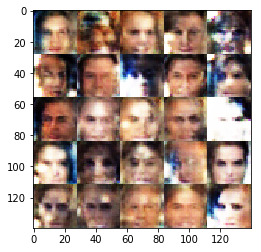

Epoch: 1/1; Batch:  2825; Discriminator Loss: 1.1941... Generator Loss: 0.8533
Epoch: 1/1; Batch:  2850; Discriminator Loss: 0.9629... Generator Loss: 0.9704
Epoch: 1/1; Batch:  2875; Discriminator Loss: 1.0728... Generator Loss: 0.9995
Epoch: 1/1; Batch:  2900; Discriminator Loss: 0.4898... Generator Loss: 2.0806
Epoch: 1/1; Batch:  2925; Discriminator Loss: 1.4743... Generator Loss: 1.5985
Epoch: 1/1; Batch:  2950; Discriminator Loss: 0.9228... Generator Loss: 0.9353
Epoch: 1/1; Batch:  2975; Discriminator Loss: 0.6896... Generator Loss: 1.4834
Epoch: 1/1; Batch:  3000; Discriminator Loss: 1.1260... Generator Loss: 0.6679


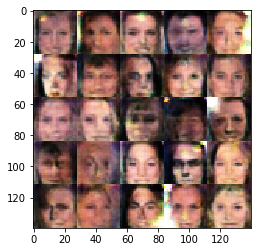

Epoch: 1/1; Batch:  3025; Discriminator Loss: 1.8040... Generator Loss: 1.6480
Epoch: 1/1; Batch:  3050; Discriminator Loss: 1.2736... Generator Loss: 0.5270
Epoch: 1/1; Batch:  3075; Discriminator Loss: 0.9401... Generator Loss: 0.8635
Epoch: 1/1; Batch:  3100; Discriminator Loss: 0.8305... Generator Loss: 1.0146
Epoch: 1/1; Batch:  3125; Discriminator Loss: 0.9027... Generator Loss: 0.9872
Epoch: 1/1; Batch:  3150; Discriminator Loss: 0.8904... Generator Loss: 1.0175


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.